<a href="https://colab.research.google.com/github/hufahamdika/BigData_Final-Project/blob/main/Final_Project_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Big Data Final Project
- Name : Abidjanna Zulfa Hamdika
- Student ID : 5025201197
- Class : Big Data A



# Load Data

In [2]:
# set up Java Dev Kit and download Spark and Hadoop
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget https://downloads.apache.org/spark/spark-3.2.4/spark-3.2.4-bin-hadoop3.2.tgz

# unpack Spark and Hadoop
!tar xf spark-3.2.4-bin-hadoop3.2.tgz

# set up home paths for Java and Spark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.4-bin-hadoop3.2"

--2023-06-15 16:53:30--  https://downloads.apache.org/spark/spark-3.2.4/spark-3.2.4-bin-hadoop3.2.tgz
Resolving downloads.apache.org (downloads.apache.org)... 88.99.95.219, 135.181.214.104, 2a01:4f9:3a:2c57::2, ...
Connecting to downloads.apache.org (downloads.apache.org)|88.99.95.219|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 301183180 (287M) [application/x-gzip]
Saving to: ‘spark-3.2.4-bin-hadoop3.2.tgz’

spark-3.2.4-bin-had 100%[===================>] 287.23M  19.3MB/s    in 16s     

2023-06-15 16:53:47 (18.1 MB/s) - ‘spark-3.2.4-bin-hadoop3.2.tgz’ saved [301183180/301183180]



In [3]:
# install, import and initialise findspark
!pip install -q findspark
import findspark
findspark.init()

# set up spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

In [4]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
# Download dataset from kaggle link

import opendatasets as od
od.download("https://www.kaggle.com/datasets/ifteshanajnin/carinsuranceclaimprediction-classification?select=train.csv")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: marvesco
Your Kaggle Key: ··········


100%|██████████| 1.96M/1.96M [00:00<00:00, 144MB/s]

In [339]:
from pyspark.sql.functions import when, count, isnull, isnan, col, mean, stddev
from functools import reduce
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.stat import Correlation
import pandas as pd
import matplotlib.pyplot as plt
import math
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator, MulticlassMetrics
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [144]:
# Read dataset as csv
df = spark.read.csv('carinsuranceclaimprediction-classification/train.csv', header=True, inferSchema=True)
df.show()

+---------+-----------------+----------+-------------------+------------+------------------+----+-------+-----+---------+--------------+-----------------+--------------------+-------+------+----------------------+-------+------------------+-----------------+----------------+------------+--------+-----------------+--------+-------------+--------------+------+-----+------+------------+-------------------+--------------------+---------------------+-----------------------+---------------+-------------------+------------------+-----------------+--------------------------------+-----------------------------+------+--------------+-----------+--------+
|policy_id|    policy_tenure|age_of_car|age_of_policyholder|area_cluster|population_density|make|segment|model|fuel_type|    max_torque|        max_power|         engine_type|airbags|is_esc|is_adjustable_steering|is_tpms|is_parking_sensors|is_parking_camera|rear_brakes_type|displacement|cylinder|transmission_type|gear_box|steering_type|turning_r

In [145]:
df.printSchema()

root
 |-- policy_id: string (nullable = true)
 |-- policy_tenure: double (nullable = true)
 |-- age_of_car: double (nullable = true)
 |-- age_of_policyholder: double (nullable = true)
 |-- area_cluster: string (nullable = true)
 |-- population_density: integer (nullable = true)
 |-- make: integer (nullable = true)
 |-- segment: string (nullable = true)
 |-- model: string (nullable = true)
 |-- fuel_type: string (nullable = true)
 |-- max_torque: string (nullable = true)
 |-- max_power: string (nullable = true)
 |-- engine_type: string (nullable = true)
 |-- airbags: integer (nullable = true)
 |-- is_esc: string (nullable = true)
 |-- is_adjustable_steering: string (nullable = true)
 |-- is_tpms: string (nullable = true)
 |-- is_parking_sensors: string (nullable = true)
 |-- is_parking_camera: string (nullable = true)
 |-- rear_brakes_type: string (nullable = true)
 |-- displacement: integer (nullable = true)
 |-- cylinder: integer (nullable = true)
 |-- transmission_type: string (nulla

In [146]:
# Check dataset shape
print(f"Shape: ({df.count()}, {len(df.columns)})")

Shape: (58592, 44)


In [147]:
cols = df.columns

# show count of when the column is null for each of those columns
df.select([count(when(isnull(c), c)).alias(c) for c in cols]).show()

+---------+-------------+----------+-------------------+------------+------------------+----+-------+-----+---------+----------+---------+-----------+-------+------+----------------------+-------+------------------+-----------------+----------------+------------+--------+-----------------+--------+-------------+--------------+------+-----+------+------------+-------------------+--------------------+---------------------+-----------------------+---------------+-------------------+------------------+-----------------+--------------------------------+-----------------------------+------+--------------+-----------+--------+
|policy_id|policy_tenure|age_of_car|age_of_policyholder|area_cluster|population_density|make|segment|model|fuel_type|max_torque|max_power|engine_type|airbags|is_esc|is_adjustable_steering|is_tpms|is_parking_sensors|is_parking_camera|rear_brakes_type|displacement|cylinder|transmission_type|gear_box|steering_type|turning_radius|length|width|height|gross_weight|is_front_fo

In [148]:
# Renaming dataset so that it don't use a special characters
oldColumns = df.columns
newColumns = ['policy_id', 'policy_tenure', 'age_of_car', 'age_of_policyholder',
  'area_cluster', 'population_density', 'make', 'segment', 'model', 'fuel_type',
  'max_torque', 'max_power', 'engine_type', 'airbags', 'is_esc', 'is_adjustable_steering',
  'is_tpms', 'is_parking_sensors', 'is_parking_camera', 'rear_brakes_type', 'displacement',
 'cylinder', 'transmission_type', 'gear_box', 'steering_type', 'turning_radius',
 'length', 'width', 'height', 'gross_weight', 'is_front_fog_lights', 'is_rear_window_wiper',
 'is_rear_window_washer', 'is_rear_window_defogger', 'is_brake_assist', 'is_power_door_locks',
 'is_central_locking', 'is_power_steering', 'is_driver_seat_height_adjustable',
 'is_day_night_rear_view_mirror', 'is_ecw', 'is_speed_alert','ncap_rating','is_claim']

df = reduce(lambda df, idx: df.withColumnRenamed(oldColumns[idx], newColumns[idx]), range(len(oldColumns)), df)
df.printSchema()
df.show()

root
 |-- policy_id: string (nullable = true)
 |-- policy_tenure: double (nullable = true)
 |-- age_of_car: double (nullable = true)
 |-- age_of_policyholder: double (nullable = true)
 |-- area_cluster: string (nullable = true)
 |-- population_density: integer (nullable = true)
 |-- make: integer (nullable = true)
 |-- segment: string (nullable = true)
 |-- model: string (nullable = true)
 |-- fuel_type: string (nullable = true)
 |-- max_torque: string (nullable = true)
 |-- max_power: string (nullable = true)
 |-- engine_type: string (nullable = true)
 |-- airbags: integer (nullable = true)
 |-- is_esc: string (nullable = true)
 |-- is_adjustable_steering: string (nullable = true)
 |-- is_tpms: string (nullable = true)
 |-- is_parking_sensors: string (nullable = true)
 |-- is_parking_camera: string (nullable = true)
 |-- rear_brakes_type: string (nullable = true)
 |-- displacement: integer (nullable = true)
 |-- cylinder: integer (nullable = true)
 |-- transmission_type: string (nulla

# Data Preprocessing

In [149]:
plot_cols = ['policy_tenure', 'age_of_car', 'age_of_policyholder',
             'population_density', 'airbags', 'displacement',
             'cylinder', 'gear_box', 'turning_radius',
             'length', 'width', 'height', 'gross_weight']

len(plot_cols)

13

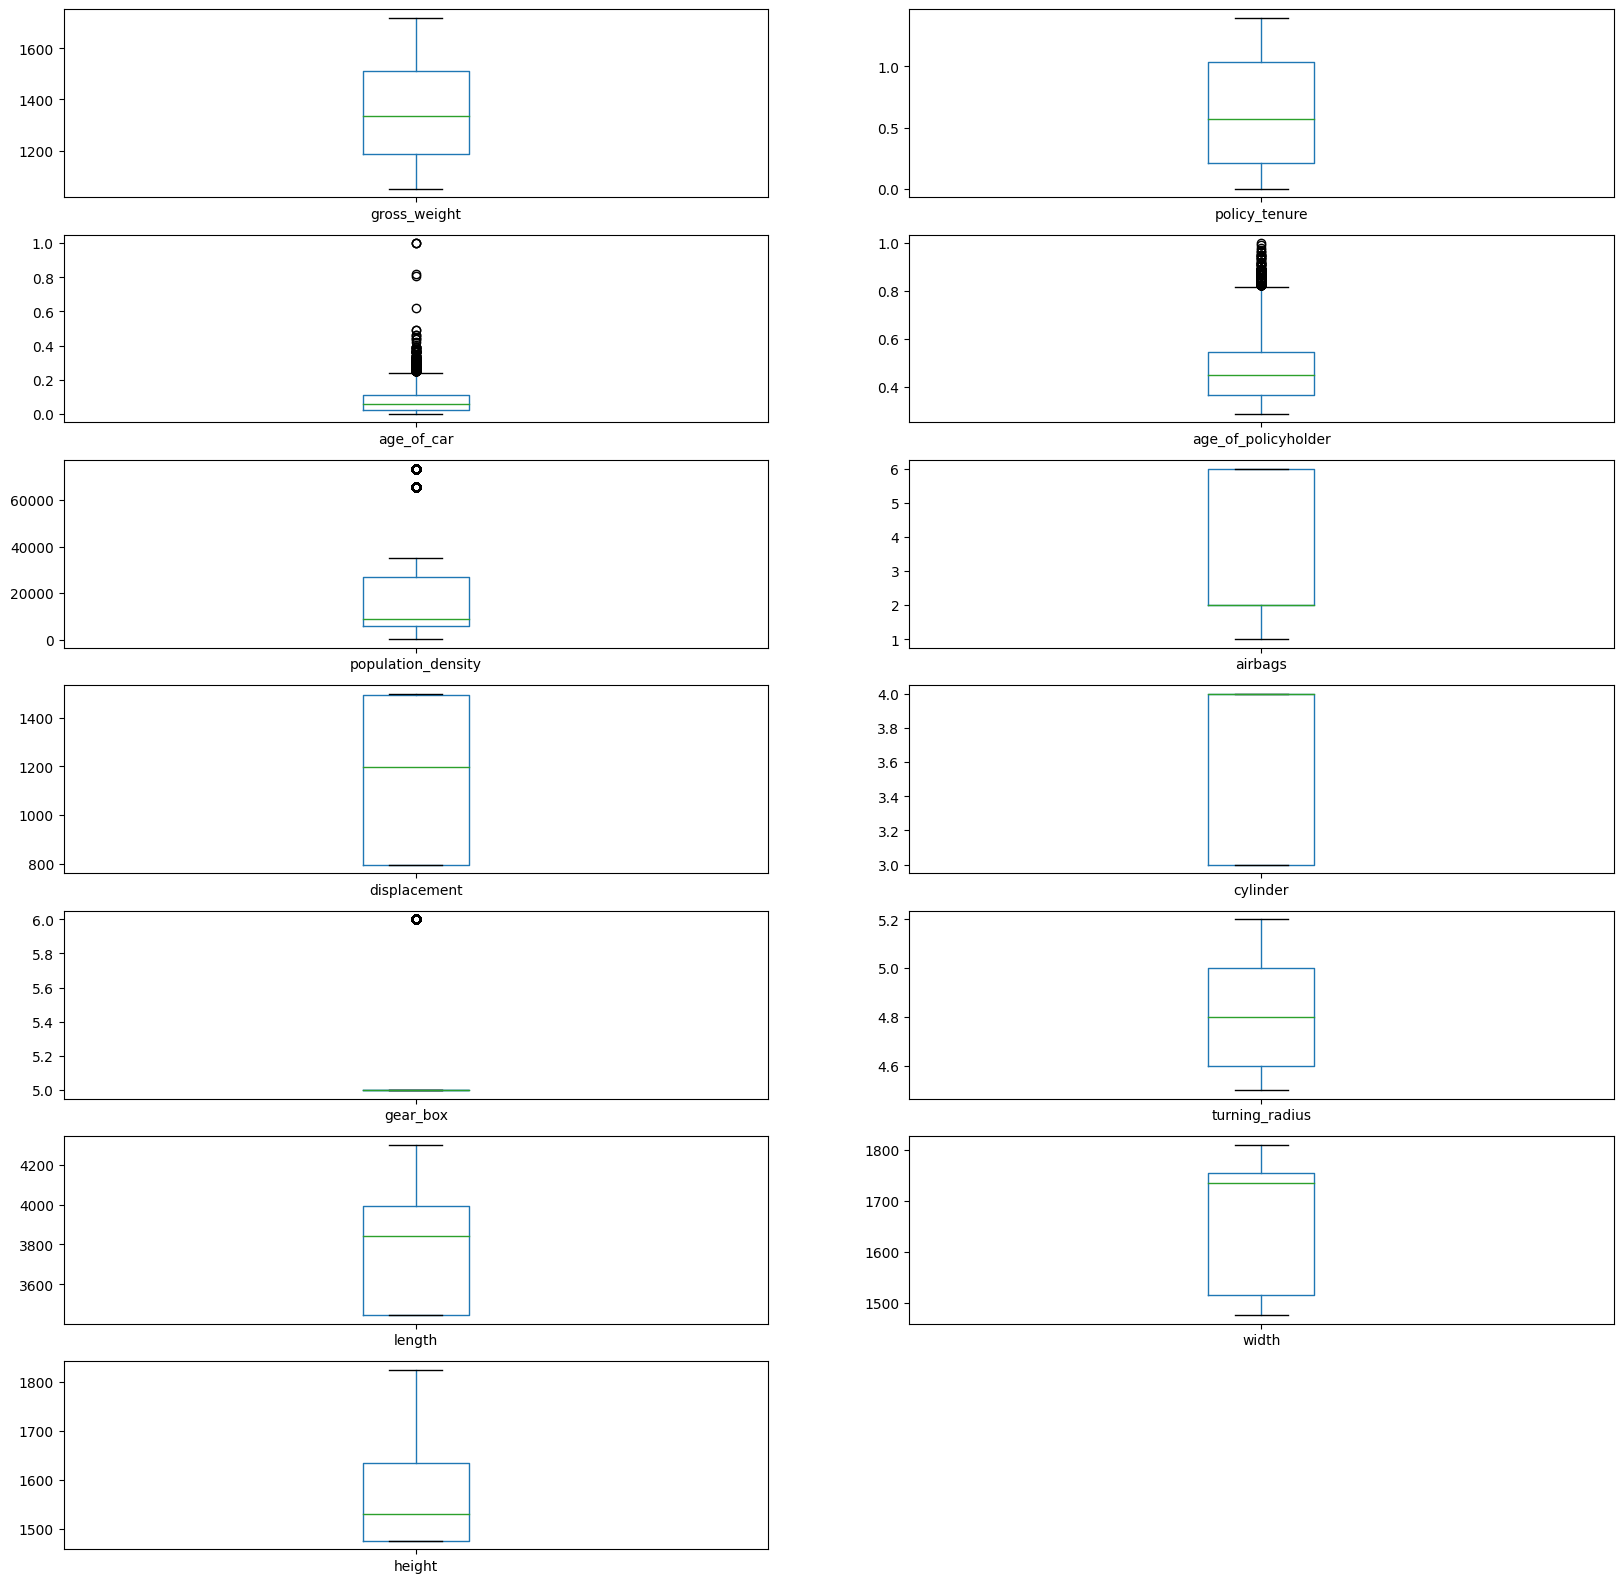

In [150]:
# Checking for outliers in the numeric columns

pandas_df = df.toPandas()

plot_cols = ['policy_tenure', 'age_of_car', 'age_of_policyholder',
             'population_density', 'airbags', 'displacement',
             'cylinder', 'gear_box', 'turning_radius',
             'length', 'width', 'height', 'gross_weight', ]

plt.figure(figsize=(20, 20))
for i in range(0, len(plot_cols)):
    plt.subplot(math.ceil(len(plot_cols)/2), 2, i + 1)
    pandas_df.boxplot(column=plot_cols[i-1], grid=False)

del pandas_df

# Result tells us that the outliers is just to much, probably best if we didn't handle the outliers

In [151]:
col_outliers = ['gross_weight', 'policy_tenure', 'age_of_car', 'displacement']

In [152]:
def z_score_outliers(df, columns, threshold=3.0):
    """
    Detects and removes outliers from a PySpark DataFrame using the z-score method.

    :param df: PySpark DataFrame
    :param columns: list of column names for which outliers should be removed
    :param threshold: z-score threshold to determine outliers (default is 3.0)
    :return: PySpark DataFrame with outliers removed
    """
    for column in columns:
        # Calculate mean and standard deviation
        stats = df.select(mean(col(column)).alias('mean'), stddev(col(column)).alias('stddev')).collect()[0]

        # Calculate z-scores and filter outliers
        df = df.withColumn(f'{column}_z_score', (col(column) - stats['mean']) / stats['stddev']) \
               .filter(f'abs({column}_z_score) <= {threshold}') \
               .drop(f'{column}_z_score')

    return df

In [153]:
df_z_score_outliers = z_score_outliers(df, col_outliers, threshold=3)

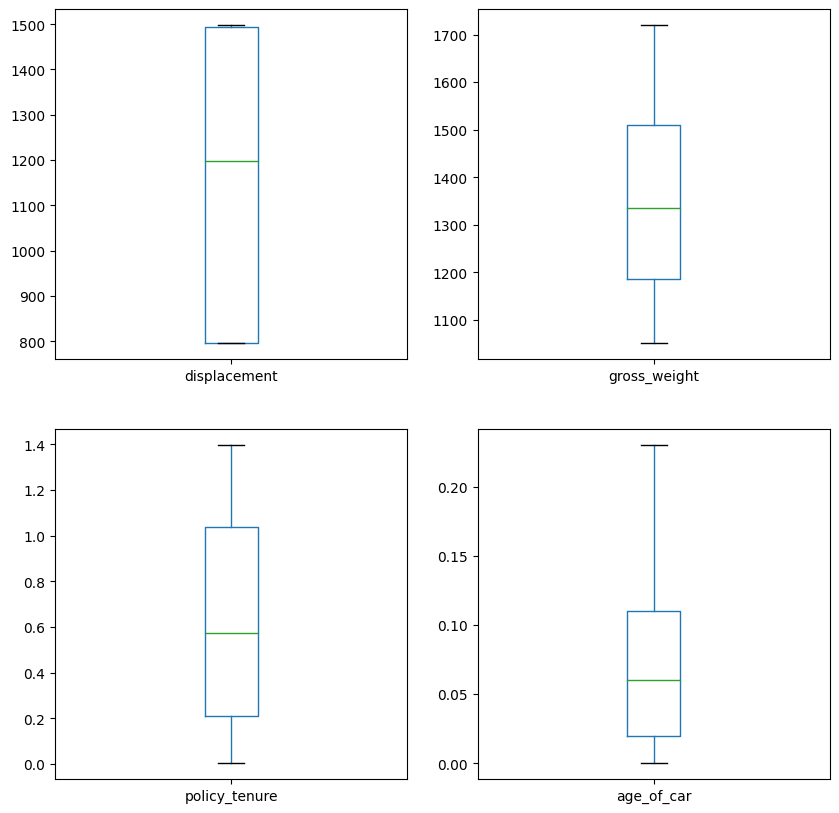

In [154]:
pandas_df_outliers = df_z_score_outliers.toPandas()

plt.figure(figsize=(10, 10))
for i in range(0, len(col_outliers)):
    plt.subplot(math.ceil(len(col_outliers)/2), 2, i + 1)
    pandas_df_outliers.boxplot(column=col_outliers[i-1], grid=False)

del pandas_df_outliers

In [155]:
df_z_score_outliers.show()
df = df_z_score_outliers
del df_z_score_outliers

+---------+-----------------+----------+-------------------+------------+------------------+----+-------+-----+---------+--------------+-----------------+--------------------+-------+------+----------------------+-------+------------------+-----------------+----------------+------------+--------+-----------------+--------+-------------+--------------+------+-----+------+------------+-------------------+--------------------+---------------------+-----------------------+---------------+-------------------+------------------+-----------------+--------------------------------+-----------------------------+------+--------------+-----------+--------+
|policy_id|    policy_tenure|age_of_car|age_of_policyholder|area_cluster|population_density|make|segment|model|fuel_type|    max_torque|        max_power|         engine_type|airbags|is_esc|is_adjustable_steering|is_tpms|is_parking_sensors|is_parking_camera|rear_brakes_type|displacement|cylinder|transmission_type|gear_box|steering_type|turning_r

In [205]:
# Categorize Columns
# Encoding that the order matters
cat_columns = ['make', 'max_torque', 'max_power', 'is_esc', 'is_adjustable_steering',
               'is_tpms', 'is_parking_sensors', 'is_parking_camera', 'length', 'width',
               'height', 'gross_weight', 'is_front_fog_lights', 'is_rear_window_wiper',
               'is_rear_window_washer', 'is_rear_window_defogger', 'is_brake_assist', 'is_power_door_locks',
               'is_central_locking', 'is_power_steering', 'is_driver_seat_height_adjustable',
               'is_day_night_rear_view_mirror', 'is_ecw', 'is_speed_alert']

# Encoding that the order doesn't matter
one_hot_columns = ['area_cluster', 'segment', 'model', 'fuel_type',
                   'engine_type', 'rear_brakes_type', 'transmission_type',
                   'steering_type']

# Pure numerical columns
numerical_columns = ['policy_tenure', 'age_of_car', 'age_of_policyholder',
                     'population_density', 'airbags', 'displacement', 'cylinder',
                     'gear_box', 'turning_radius', 'ncap_rating']

print(len(cat_columns) + len(one_hot_columns) + len(numerical_columns))
print(len(df.columns))

42
44


In [324]:
df_preprocess = df
df_preprocess.columns

['policy_id',
 'policy_tenure',
 'age_of_car',
 'age_of_policyholder',
 'area_cluster',
 'population_density',
 'make',
 'segment',
 'model',
 'fuel_type',
 'max_torque',
 'max_power',
 'engine_type',
 'airbags',
 'is_esc',
 'is_adjustable_steering',
 'is_tpms',
 'is_parking_sensors',
 'is_parking_camera',
 'rear_brakes_type',
 'displacement',
 'cylinder',
 'transmission_type',
 'gear_box',
 'steering_type',
 'turning_radius',
 'length',
 'width',
 'height',
 'gross_weight',
 'is_front_fog_lights',
 'is_rear_window_wiper',
 'is_rear_window_washer',
 'is_rear_window_defogger',
 'is_brake_assist',
 'is_power_door_locks',
 'is_central_locking',
 'is_power_steering',
 'is_driver_seat_height_adjustable',
 'is_day_night_rear_view_mirror',
 'is_ecw',
 'is_speed_alert',
 'ncap_rating',
 'is_claim']

In [325]:
## Seems like there are weird problem in some of the columns
## String Indexer and some other function can't use a certain columns
## If I force to use these problematic columns I will get the error below

for column in df_preprocess.columns:
    if column in cat_columns or column in one_hot_columns:
        indexer = StringIndexer(inputCol=column, outputCol=f'{column}-numeric')
        df_preprocess = df_preprocess.drop(column)
        indexer_fitted = indexer.fit(df_preprocess)
        df_preprocess = indexer_fitted.transform(df_preprocess)

    if column in one_hot_columns:
        encoder = OneHotEncoder(inputCol=f'{column}-numeric', outputCol=f'{column}-onehot')
        df_preprocess = df_preprocess.drop(f'{column}-numeric')
        df_preprocess_onehot = encoder.fit(df_preprocess)
        df_preprocess = df_preprocess_onehot.transform(df_preprocess)

df_preprocess.show()

Py4JJavaError: ignored

In [326]:
# I then decide, to avoid future problem, decided to drop all of these problematic columns

problematic_columns = []
for column in df_preprocess.columns:
    try:
        if column in cat_columns or column in one_hot_columns:
            indexer = StringIndexer(inputCol=column, outputCol=f'{column}-numeric')
            df_preprocess = df_preprocess.drop(column)
            indexer_fitted = indexer.fit(df_preprocess)
            df_preprocess = indexer_fitted.transform(df_preprocess)

        if column in one_hot_columns:
            encoder = OneHotEncoder(inputCol=f'{column}-numeric', outputCol=f'{column}-onehot')
            df_preprocess = df_preprocess.drop(f'{column}-numeric')
            df_preprocess_onehot = encoder.fit(df_preprocess)
            df_preprocess = df_preprocess_onehot.transform(df_preprocess)

    except:
        problematic_columns.append(column)

print(f'df_preprocess columns length : {len(df_preprocess.columns)}')
df_preprocess.show()
print()
print(f'problematic columns length : {len(problematic_columns)}')
problematic_columns

df_preprocess columns length : 12
+---------+-----------------+----------+-------------------+------------------+-------+------------+--------+--------+--------------+-----------+--------+
|policy_id|    policy_tenure|age_of_car|age_of_policyholder|population_density|airbags|displacement|cylinder|gear_box|turning_radius|ncap_rating|is_claim|
+---------+-----------------+----------+-------------------+------------------+-------+------------+--------+--------+--------------+-----------+--------+
|  ID00001|0.515873589958172|      0.05|  0.644230769230769|              4990|      2|         796|       3|       5|           4.6|          0|       0|
|  ID00002|0.672618513547733|      0.02|              0.375|             27003|      2|         796|       3|       5|           4.6|          0|       0|
|  ID00003|0.841110255796233|      0.02|  0.384615384615385|              4076|      2|         796|       3|       5|           4.6|          0|       0|
|  ID00004|0.900276558749967|      0

['make',
 'segment',
 'model',
 'fuel_type',
 'max_torque',
 'max_power',
 'engine_type',
 'is_esc',
 'is_adjustable_steering',
 'is_tpms',
 'is_parking_sensors',
 'is_parking_camera',
 'rear_brakes_type',
 'transmission_type',
 'steering_type',
 'length',
 'width',
 'height',
 'gross_weight',
 'is_front_fog_lights',
 'is_rear_window_wiper',
 'is_rear_window_washer',
 'is_rear_window_defogger',
 'is_brake_assist',
 'is_power_door_locks',
 'is_central_locking',
 'is_power_steering',
 'is_driver_seat_height_adjustable',
 'is_day_night_rear_view_mirror',
 'is_ecw',
 'is_speed_alert']

In [327]:
## Adding missed column
problematic_columns.append('area_cluster')
problematic_columns

['make',
 'segment',
 'model',
 'fuel_type',
 'max_torque',
 'max_power',
 'engine_type',
 'is_esc',
 'is_adjustable_steering',
 'is_tpms',
 'is_parking_sensors',
 'is_parking_camera',
 'rear_brakes_type',
 'transmission_type',
 'steering_type',
 'length',
 'width',
 'height',
 'gross_weight',
 'is_front_fog_lights',
 'is_rear_window_wiper',
 'is_rear_window_washer',
 'is_rear_window_defogger',
 'is_brake_assist',
 'is_power_door_locks',
 'is_central_locking',
 'is_power_steering',
 'is_driver_seat_height_adjustable',
 'is_day_night_rear_view_mirror',
 'is_ecw',
 'is_speed_alert',
 'area_cluster']

In [328]:
# Acquiring all features that is not problematic

unproblematic_columns = []
for column in cat_columns:
    if column not in problematic_columns:
        unproblematic_columns.append(column)

for column in one_hot_columns:
    if column not in problematic_columns:
        unproblematic_columns.append(column)

for column in numerical_columns:
    if column not in problematic_columns:
        unproblematic_columns.append(column)

print(len(unproblematic_columns))
unproblematic_columns

10


['policy_tenure',
 'age_of_car',
 'age_of_policyholder',
 'population_density',
 'airbags',
 'displacement',
 'cylinder',
 'gear_box',
 'turning_radius',
 'ncap_rating']

## Feature Selections

In [329]:
# Select the real numeric values (not categorical) for correlation heatmap
corr_cols = unproblematic_columns
corr_cols.append('is_claim')
assembler = VectorAssembler(inputCols=corr_cols, outputCol='corr_features')
df_vector = assembler.transform(df_preprocess).select('corr_features')

# Creating the heatmap
matrix = Correlation.corr(df_vector, 'corr_features').collect()[0][0]
corr_matrix = matrix.toArray().tolist()
corr_matrix_df = pd.DataFrame(data=corr_matrix, columns=corr_cols, index=corr_cols)
corr_matrix_df.style.background_gradient().set_precision(2)

/content/spark-3.2.4-bin-hadoop3.2/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
<ipython-input-329-5a547d10901b>:11: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr_matrix_df.style.background_gradient().set_precision(2)


,policy_tenure,age_of_car,age_of_policyholder,population_density,airbags,displacement,cylinder,gear_box,turning_radius,ncap_rating,is_claim
policy_tenure,1.00,0.17,0.14,-0.10,0.10,0.19,0.19,0.10,0.17,0.17,0.08
age_of_car,0.17,1.00,-0.05,-0.06,0.22,0.40,0.39,0.21,0.34,0.36,-0.03
age_of_policyholder,0.14,-0.05,1.00,0.01,-0.01,-0.03,0.00,-0.00,-0.02,-0.03,0.02
population_density,-0.10,-0.06,0.01,1.00,-0.06,-0.09,-0.09,-0.06,-0.08,-0.07,-0.02
airbags,0.10,0.22,-0.01,-0.06,1.00,0.66,0.48,0.86,0.81,0.34,0.00
displacement,0.19,0.40,-0.03,-0.09,0.66,1.00,0.87,0.69,0.88,0.85,0.01
cylinder,0.19,0.39,0.00,-0.09,0.48,0.87,1.00,0.41,0.62,0.60,0.01
gear_box,0.10,0.21,-0.00,-0.06,0.86,0.69,0.41,1.00,0.86,0.53,-0.00
turning_radius,0.17,0.34,-0.02,-0.08,0.81,0.88,0.62,0.86,1.00,0.78,0.00
ncap_rating,0.17,0.36,-0.03,-0.07,0.34,0.85,0.60,0.53,0.78,1.00,0.00


In [330]:
del df_vector
del matrix
del corr_matrix
del corr_matrix_df

In [331]:
## dropped lowest coleration -> age_of_policy_holder, population_density
selected_columns = unproblematic_columns

selected_columns.remove('age_of_policyholder')
selected_columns.remove('population_density')

df_preprocess = df_preprocess.drop('age_of_policyholder')
df_preprocess = df_preprocess.drop('population_density')

df_preprocess.show()

+---------+-----------------+----------+-------+------------+--------+--------+--------------+-----------+--------+
|policy_id|    policy_tenure|age_of_car|airbags|displacement|cylinder|gear_box|turning_radius|ncap_rating|is_claim|
+---------+-----------------+----------+-------+------------+--------+--------+--------------+-----------+--------+
|  ID00001|0.515873589958172|      0.05|      2|         796|       3|       5|           4.6|          0|       0|
|  ID00002|0.672618513547733|      0.02|      2|         796|       3|       5|           4.6|          0|       0|
|  ID00003|0.841110255796233|      0.02|      2|         796|       3|       5|           4.6|          0|       0|
|  ID00004|0.900276558749967|      0.11|      2|        1197|       4|       5|           4.8|          2|       0|
|  ID00005|0.596402813108729|      0.11|      2|         999|       3|       5|           5.0|          2|       0|
|  ID00006| 1.01870853782142|      0.07|      6|        1493|       4|  

## Feature Scaling

In [332]:
vecAssembler = VectorAssembler(inputCols=selected_columns, outputCol="features")
df_preprocess = vecAssembler.transform(df_preprocess.select(selected_columns))

# Scale features using StandardScaler
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
scalerModel = scaler.fit(df_preprocess)
df_preprocess = scalerModel.transform(df_preprocess)
df_preprocess = df_preprocess
df_preprocess.show()


+-----------------+----------+-------+------------+--------+--------+--------------+-----------+--------+--------------------+--------------------+
|    policy_tenure|age_of_car|airbags|displacement|cylinder|gear_box|turning_radius|ncap_rating|is_claim|            features|     scaled_features|
+-----------------+----------+-------+------------+--------+--------+--------------+-----------+--------+--------------------+--------------------+
|0.515873589958172|      0.05|      2|         796|       3|       5|           4.6|          0|       0|[0.51587358995817...|[-0.2279832951938...|
|0.672618513547733|      0.02|      2|         796|       3|       5|           4.6|          0|       0|[0.67261851354773...|[0.15055640841964...|
|0.841110255796233|      0.02|      2|         796|       3|       5|           4.6|          0|       0|[0.84111025579623...|[0.55746473253919...|
|0.900276558749967|      0.11|      2|        1197|       4|       5|           4.8|          2|       0|[0.9002

In [333]:
df_preprocess = df_preprocess.withColumnRenamed("is_claim","label")
df_preprocess.show()

+-----------------+----------+-------+------------+--------+--------+--------------+-----------+-----+--------------------+--------------------+
|    policy_tenure|age_of_car|airbags|displacement|cylinder|gear_box|turning_radius|ncap_rating|label|            features|     scaled_features|
+-----------------+----------+-------+------------+--------+--------+--------------+-----------+-----+--------------------+--------------------+
|0.515873589958172|      0.05|      2|         796|       3|       5|           4.6|          0|    0|[0.51587358995817...|[-0.2279832951938...|
|0.672618513547733|      0.02|      2|         796|       3|       5|           4.6|          0|    0|[0.67261851354773...|[0.15055640841964...|
|0.841110255796233|      0.02|      2|         796|       3|       5|           4.6|          0|    0|[0.84111025579623...|[0.55746473253919...|
|0.900276558749967|      0.11|      2|        1197|       4|       5|           4.8|          2|    0|[0.90027655874996...|[0.7003

In [395]:
# pandas_df = df_preprocess.toPandas()
# train_size = int(0.8 *len(pandas_df))

# pandas_train_df = pandas_df[:train_size]
# trainingData = spark.createDataFrame(pandas_train_df)
# del pandas_train_df

# pandas_test_df = pandas_df[train_size:]
# testData = spark.createDataFrame(pandas_test_df)
# del pandas_test_df

/content/spark-3.2.4-bin-hadoop3.2/python/pyspark/sql/pandas/conversion.py:371: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


In [308]:
# policy = df.select('policy_id', 'policy_tenure')

In [309]:
# preprocess_pandas = df_preprocess.toPandas()
# policy_pandas = policy.toPandas()

In [ ]:
# preprocess_pandas = df_preprocess.toPandas()
# policy_pandas = df.select('policy_id').toPandas

# preprocess_pandas['policy_id'] = policy_pandas['policy_id'].values
# df_from_pandas = spark.createDataFrame(preprocess_pandas)

# df_from_pandas.show()

In [419]:
(trainingData, testData) = df_preprocess.randomSplit([0.8, 0.2], seed=100)
print(trainingData.count())
print(testData.count())

46671
11587


# Modeling

## Logistic Regression

In [420]:
# Create initial LogisticRegression model
lr = LogisticRegression(labelCol="label", featuresCol="scaled_features", maxIter=10)

# Train model with Training Data
lrModel = lr.fit(trainingData)

In [421]:
# Make predictions on test data using the transform() method.
# LogisticRegression.transform() will only use the 'features' column.
predictions = lrModel.transform(testData)
predictions.show()

+-----------------+----------+-------+------------+--------+--------+--------------+-----------+-----+--------------------+--------------------+--------------------+--------------------+----------+
|    policy_tenure|age_of_car|airbags|displacement|cylinder|gear_box|turning_radius|ncap_rating|label|            features|     scaled_features|       rawPrediction|         probability|prediction|
+-----------------+----------+-------+------------+--------+--------+--------------+-----------+-----+--------------------+--------------------+--------------------+--------------------+----------+
|0.002747851054561|      0.08|      2|        1197|       4|       5|           4.8|          2|    0|[0.00274785105456...|[-1.4671842892220...|[8.95361471391268...|[0.99987074766443...|       0.0|
|0.002770853710949|      0.01|      2|        1197|       4|       5|           4.8|          2|    0|[0.00277085371094...|[-1.4671287377022...|[8.94705533328493...|[0.99986989717317...|       0.0|
| 0.002772

In [422]:
# Evaluate model
evaluator = BinaryClassificationEvaluator()
evaluator.evaluate(predictions)


0.9999988452344751

In [423]:
print(lr.explainParams())

aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)
family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)
featuresCol: features column name. (default: features, current: scaled_features)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label, current: label)
lowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)
lowerBoundsOnIntercepts: The lower bounds on intercepts if fitting under bound constrained optimizati

In [424]:
# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.1, 0.5, 1.25, 2])
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
             .addGrid(lr.maxIter, [1, 5, 10])
             .build())


In [345]:
# Create 5-fold CrossValidator
cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

# Run cross validations
cvModel = cv.fit(trainingData)


In [401]:
best_model = cvModel.bestModel

print('Best regParam: ',best_model._java_obj.getRegParam())
print('Best elasticNetParam: ', best_model._java_obj.getElasticNetParam())
print('Best maxIter: ', best_model._java_obj.getMaxIter())

Best regParam:  0.1
Best elasticNetParam:  0.5
Best maxIter:  1


In [425]:
# Measure the accuracy on training data and test data
predictions_train = best_model.transform(trainingData)
predictions_test = best_model.transform(testData)

In [426]:
# Create an evaluator for accuracy.
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy = evaluator.evaluate(predictions_train)
print(f'Train Accuracy: {accuracy}')

accuracy = evaluator.evaluate(predictions_test)
print(f'Test Accuracy: {accuracy}')

Train Accuracy: 0.9352488697478092
Test Accuracy: 0.9381203072408734


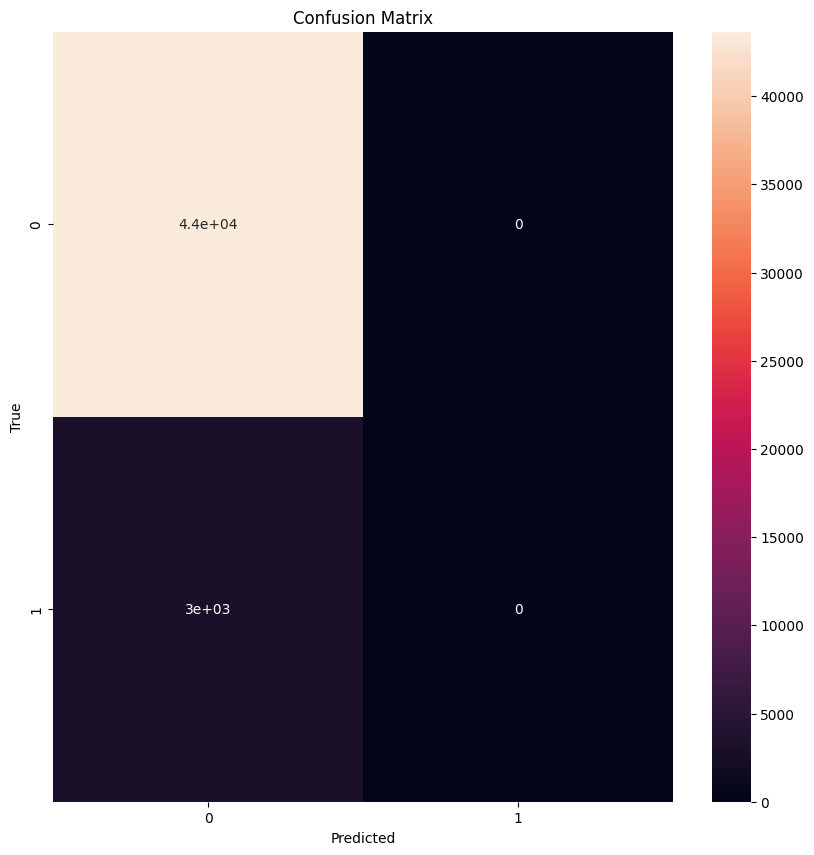

In [427]:
train_prediction = predictions_train.select("prediction", "label")
pandas_trainpred = train_prediction.toPandas()

cm = confusion_matrix(pandas_trainpred['label'], pandas_trainpred['prediction'])
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [428]:
del pandas_trainpred

In [407]:
test_prediction = predictions.select("prediction", "label")
pandas_testpred = test_prediction.toPandas()

In [408]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

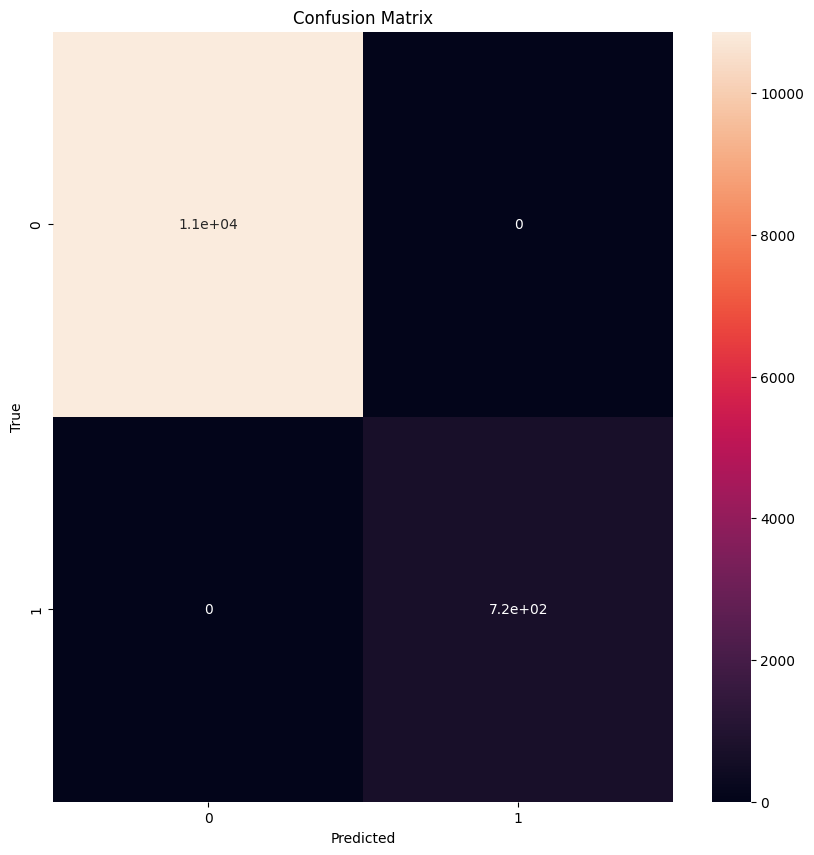

In [429]:
test_prediction = predictions.select("prediction", "label")
pandas_testpred = test_prediction.toPandas()

cm = confusion_matrix(pandas_testpred['label'], pandas_testpred['prediction'])
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [430]:
del pandas_testpred